# Cycle Streets API - Collisions Data

__March 2022__

This notebook pulls some data from the Cycle Streets API for information on collisions on London streets.

This needs to be done in two parts:
1. Pull collisisions data from lat / long grids - https://www.cyclestreets.net/api/v2/collisions.locations/#example
2. Pull additional data on collisions from the above collisions using their IDs

The aim is to collate the data into some kind of csv data that will be easy to analyse going forward. Depending on size, some kind of simple database might be a good idea.

In [1]:
import os
import time
import requests
import numpy as np
import pandas as pd
import itertools
import seaborn as sns
import matplotlib.pyplot as plt

from dotenv import load_dotenv

load_dotenv()
api_key = os.getenv('CYCLE_STREETS_API_KEY')

%config InlineBackend.figure_format = 'retina'

sns.set_palette('Set2')
plt.rcParams["font.family"] = "Calibri"
plt.rcParams["font.size"] = 12

## 1 - Pull Collisions Data

Firstly, test how to pull from the API, then pull data for inner London grid

In [232]:
base_url = 'https://api.cyclestreets.net/v2/collisions.locations'
bbox = '0.1252,52.1979,0.1302,52.1999'
casualties_include = 'cyclist'
limit = 2000
datetime = 'sqldatetime'
jitter = 1
zoom = 17
severity = 'fatal,serious'

url = f'{base_url}?bbox={bbox}&casualtiesinclude={casualties_include}&limit={limit}&datetime={datetime}&jitter={jitter}&zoom={zoom}&field:severity={severity}'

In [233]:
r = requests.get(url, params={'key': api_key})

properties = [feature['properties'] for feature in r.json()['features']]

results = pd.DataFrame(properties)
results.head()

,id,datetime,severity,casualties,number_of_casualties,number_of_vehicles,url,apiUrl,latitude,longitude
0,2009350166609,2009-05-26 14:34:00,serious,Cyclist,1,2,https://www.cyclestreets.net/collisions/report...,https://api.cyclestreets.net/v2/collisions.loc...,52.199203,0.127124
1,2012350237312,2012-05-25 09:00:00,serious,Cyclist,1,2,https://www.cyclestreets.net/collisions/report...,https://api.cyclestreets.net/v2/collisions.loc...,52.198328,0.125765
2,2013353084513,2013-10-04 18:55:00,serious,Cyclist,2,2,https://www.cyclestreets.net/collisions/report...,https://api.cyclestreets.net/v2/collisions.loc...,52.199108,0.127413
3,2017350172418,2017-03-05 16:30:00,serious,Cyclist,1,2,https://www.cyclestreets.net/collisions/report...,https://api.cyclestreets.net/v2/collisions.loc...,52.198174,0.128301
4,2019350861082,2019-07-22 16:30:00,serious,Cyclist,1,2,https://www.cyclestreets.net/collisions/report...,https://api.cyclestreets.net/v2/collisions.loc...,52.199154,0.127338


### Test pulling from a different bbox

Define small lat/lon grid in London to pull from.

In [168]:
increment = .01

bottom_left = [-0.198659, 51.469760]
top_right = [bottom_left[0] + increment, bottom_left[1] + increment]

bbox = f'{bottom_left[0]},{bottom_left[1]},{top_right[0]},{top_right[1]}'
bbox

'-0.198659,51.46976,-0.188659,51.47976'

In [169]:
url = f'{base_url}?bbox={bbox}&casualtiesinclude={casualties_include}&limit={limit}&datetime={datetime}&jitter={jitter}&zoom={zoom}&field:severity={severity}'

r = requests.get(url, params={'key': api_key})

properties = [feature['properties'] for feature in r.json()['features']]

results = pd.DataFrame(properties)
results.head()

,id,datetime,severity,casualties,number_of_casualties,number_of_vehicles,url,apiUrl,latitude,longitude
0,199901FH00672,1999-09-22 12:35:00,serious,Cyclist,1,2,https://www.cyclestreets.net/collisions/report...,https://api.cyclestreets.net/v2/collisions.loc...,51.472928,-0.198289
1,200001FH00407,2000-05-18 20:00:00,serious,Cyclist,1,2,https://www.cyclestreets.net/collisions/report...,https://api.cyclestreets.net/v2/collisions.loc...,51.478096,-0.189301
2,200001FH00966,2000-11-09 09:09:00,serious,Cyclist,1,2,https://www.cyclestreets.net/collisions/report...,https://api.cyclestreets.net/v2/collisions.loc...,51.478186,-0.189298
3,200101FH00579,2001-07-25 22:02:00,serious,Cyclist,1,2,https://www.cyclestreets.net/collisions/report...,https://api.cyclestreets.net/v2/collisions.loc...,51.477515,-0.192492
4,200101FH00906,2001-11-09 19:45:00,serious,Cyclist,1,2,https://www.cyclestreets.net/collisions/report...,https://api.cyclestreets.net/v2/collisions.loc...,51.475266,-0.192437


### Define grid to pull from

Will just use a rectangle as a rough proxy for 'inner' London, can refine later.

Bottom left of grid (Wandsworth town) - 51.455953, -0.198716
Top right of grid (Dalston) - 51.541914, -0.077560

Need to define a grid of points within the above boundaries.

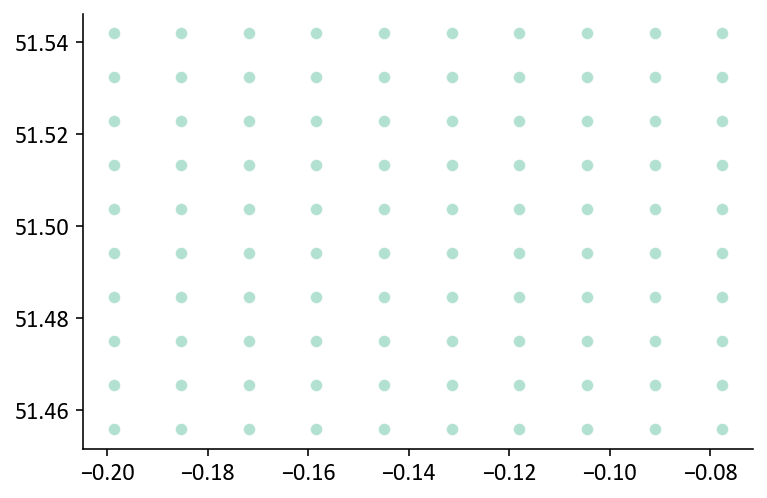

[(51.455953, -0.198716),
 (51.455953, -0.18525422222222224),
 (51.455953, -0.17179244444444444),
 (51.455953, -0.15833066666666668),
 (51.455953, -0.14486888888888888),
 (51.455953, -0.1314071111111111),
 (51.455953, -0.11794533333333335),
 (51.455953, -0.10448355555555557)]

In [4]:
latitudes = np.linspace(51.455953, 51.541914, 10)
longitudes = np.linspace(-.198716, -.077560, 10)

latitudes, longitudes

coordinates = list(itertools.product(latitudes, longitudes))

sns.scatterplot(x=[coord[1] for coord in coordinates], y=[coord[0] for coord in coordinates], alpha=.5)
sns.despine(right=True, top=True)
plt.show()

coordinates[0:8]

Turn lat,lon pairs from above into a set of squares which we can use as the bbox argument in the API query.

In [171]:
# make pairs of lat and longs with the next point along
lat_pairs, lon_pairs = [], []
for i in range(9):
    lat_pairs.append([latitudes[i], latitudes[i+1]])
    lon_pairs.append([longitudes[i], longitudes[i+1]])

grid = list(itertools.product(lat_pairs, lon_pairs))

len(grid)

81

Pull data for each grid and put into a dataframe

In [172]:
# g = grid[0]
# bbox = f'{g[1][0]},{g[0][0]},{g[1][1]},{g[0][1]}'

results_list = []
for g in grid:
    bbox = f'{g[1][0]},{g[0][0]},{g[1][1]},{g[0][1]}'
    url = f'{base_url}?bbox={bbox}&casualtiesinclude={casualties_include}&limit={limit}&datetime={datetime}&jitter={jitter}&zoom={zoom}&field:severity={severity}'

    r = requests.get(url, params={'key': api_key})

    properties = [feature['properties'] for feature in r.json()['features']]

    g_results = pd.DataFrame(properties)
    g_results['bbox'] = bbox
    
    results_list.append(g_results)

results = pd.concat(results_list)
results.head()

,id,datetime,severity,casualties,number_of_casualties,number_of_vehicles,url,apiUrl,latitude,longitude,bbox
0,199901WW00226,1999-04-26 16:25:00,serious,Cyclist,1,1,https://www.cyclestreets.net/collisions/report...,https://api.cyclestreets.net/v2/collisions.loc...,51.458087,-0.192252,"-0.198716,51.455953,-0.18525422222222224,51.46..."
1,200001WW00551,2000-05-19 23:26:00,serious,Cyclist,1,1,https://www.cyclestreets.net/collisions/report...,https://api.cyclestreets.net/v2/collisions.loc...,51.457874,-0.190102,"-0.198716,51.455953,-0.18525422222222224,51.46..."
2,200201WW01127,2002-10-24 17:26:00,serious,Cyclist,1,2,https://www.cyclestreets.net/collisions/report...,https://api.cyclestreets.net/v2/collisions.loc...,51.456636,-0.191446,"-0.198716,51.455953,-0.18525422222222224,51.46..."
3,200401WW00069,2004-01-27 18:57:00,serious,Cyclist,1,2,https://www.cyclestreets.net/collisions/report...,https://api.cyclestreets.net/v2/collisions.loc...,51.46349,-0.186856,"-0.198716,51.455953,-0.18525422222222224,51.46..."
4,200601TE00267,2006-09-27 06:46:00,serious,Cyclist,1,2,https://www.cyclestreets.net/collisions/report...,https://api.cyclestreets.net/v2/collisions.loc...,51.459595,-0.190897,"-0.198716,51.455953,-0.18525422222222224,51.46..."


Output the data to a csv

In [190]:
print(len(results))
results = results.drop_duplicates()
print(len(results))

results.to_csv('../data/collision_ids.csv', index=False)

3848
3848


## 2 - Pull Collision Reports

Next step is to use the IDs pulled in the last section to get detailed info on collisions. Each collision has the following properties:
- Accident - more detailed information on the collision
- Casualties - individual items for each casualty
- Vehicles - individual items for each vehicle involved

In [208]:
example_id = '2013353084513'

base_url = 'https://api.cyclestreets.net/v2/collisions.location'
datetime = 'sqldatetime'

url = f'{base_url}?id={example_id}&datetime={datetime}&labels=1'

r = requests.get(url, params={'key': api_key})

properties = [feature['properties'] for feature in r.json()['features']][0]
keys = properties.keys()

keys

dict_keys(['accident', 'casualties', 'vehicles', 'labels'])

Take a look at an example output

In [209]:
for key in keys:
    print(key)
    print(properties[key])

accident
{'id': '2013353084513', 'accyr': '2013', 'casualties': 'Cyclist', 'accident_year': '2013', 'accident_reference': '353084513', 'location_easting_osgr': '545490', 'location_northing_osgr': '257790', 'longitude': '0.127413', 'latitude': '52.199108', 'police_force': 'Cambridgeshire', 'accident_severity': 'Serious', 'number_of_vehicles': '2', 'number_of_casualties': '2', 'date': '2013-10-04', 'day_of_week': 'Friday', 'time': '18:55:00', 'local_authority_district': 'Cambridge', 'local_authority_ons_district': 'Cambridge', 'local_authority_highway': 'Cambridgeshire', 'first_road_class': 'A', 'first_road_number': '603', 'road_type': 'Single carriageway', 'speed_limit': '30', 'junction_detail': 'Crossroads', 'junction_control': 'Auto traffic signal', 'second_road_class': 'A', 'second_road_number': '1307', 'pedestrian_crossing_human_control': 'None within 50 metres ', 'pedestrian_crossing_physical_facilities': 'Pedestrian phase at traffic signal junction', 'light_conditions': 'Darkness 

Pull data for all collision IDs, extract info on accidents, casualties and vehicles

In [228]:
accident_list, casualty_list, vehicle_list = [], [], []
n = 0

ids = results['id'].values.tolist()
for id in ids:
    n += 1
    url = f'{base_url}?id={id}&datetime={datetime}&labels=1'

    id_pulled = False
    while id_pulled is False:
        try:
            r = requests.get(url, params={'key': api_key})
            id_pulled = True
        except ConnectionError:
            print('Sleeping for 60 seconds')
            time.sleep(60)  # sleep for 60 seconds

    properties = [feature['properties'] for feature in r.json()['features']][0]

    accident_list.append(properties['accident'])

    for key in properties['casualties'].keys():
        casualty_list.append(properties['casualties'][key])

    for key in properties['vehicles'].keys():
        vehicle_list.append(properties['vehicles'][key])

    if n % 100 == 0:
        print(f'Pulled from {n} collisions')

Pulled from 100 collisions
Pulled from 200 collisions
Pulled from 300 collisions
Pulled from 400 collisions
Pulled from 500 collisions
Pulled from 600 collisions
Pulled from 700 collisions
Pulled from 800 collisions
Pulled from 900 collisions
Pulled from 1000 collisions
Pulled from 1100 collisions
Pulled from 1200 collisions
Pulled from 1300 collisions
Pulled from 1400 collisions
Pulled from 1500 collisions
Pulled from 1600 collisions
Pulled from 1700 collisions
Pulled from 1800 collisions
Pulled from 1900 collisions
Pulled from 2000 collisions
Pulled from 2100 collisions
Pulled from 2200 collisions
Pulled from 2300 collisions
Pulled from 2400 collisions
Pulled from 2500 collisions
Pulled from 2600 collisions
Pulled from 2700 collisions
Pulled from 2800 collisions
Pulled from 2900 collisions
Pulled from 3000 collisions
Pulled from 3100 collisions
Pulled from 3200 collisions
Pulled from 3300 collisions
Pulled from 3400 collisions
Pulled from 3500 collisions
Pulled from 3600 collisions
P

Output various dataframes to csv and print sizes of datasets

In [229]:
accidents = pd.DataFrame(accident_list)
casualties = pd.DataFrame(casualty_list)
vehicles = pd.DataFrame(vehicle_list)

print(f'Accident count: {len(accidents)}')
print(f'Casualty count: {len(casualties)}')
print(f'Vehicle count: {len(vehicles)}')

display(accidents.sample(5))
display(casualties.sample(5))
display(vehicles.sample(5))

Accident count: 3848
Casualty count: 4139
Vehicle count: 7395


,id,accyr,casualties,accident_year,accident_reference,location_easting_osgr,location_northing_osgr,longitude,latitude,police_force,...,light_conditions,weather_conditions,road_surface_conditions,special_conditions_at_site,carriageway_hazards,urban_or_rural_area,did_police_officer_attend_scene_of_accident,trunk_road_flag,lsoa_of_accident_location,datetime
2461,200801CW10205,2008,Cyclist,2008,01CW10205,527190,181130,-0.168391,51.514731,Metropolitan Police,...,Darkness - lights lit,Fine no high winds,Dry,None,None,Urban,No,Non-trunk,E01004686,2008-02-29 18:00:00
1187,200501LX51162,2005,Cyclist,2005,01LX51162,531230,178600,-0.111142,51.491071,Metropolitan Police,...,Darkness - lights lit,Fine no high winds,Dry,None,None,Urban,Yes,Non-trunk,E01003111,2005-10-06 21:13:00
38,200701WW50411,2007,Cyclist,2007,01WW50411,526380,175480,-0.18208,51.464135,Metropolitan Police,...,Daylight,Fine no high winds,Dry,None,None,Urban,Yes,Non-trunk,E01004538,2007-07-02 08:29:00
3499,201201TA00060,2012,"Cyclist,Motorcycle rider/passenger",2012,01TA00060,533430,182670,-0.077933,51.527132,Metropolitan Police,...,Daylight,Fine no high winds,Dry,None,None,Urban,Yes,Non-trunk,E01001771,2012-01-09 13:28:00
3770,200501EO40716,2005,Cyclist,2005,01EO40716,531840,183770,-0.100429,51.53739,Metropolitan Police,...,Daylight,Fine no high winds,Dry,None,None,Urban,No,Non-trunk,E01002794,2005-07-20 17:10:00


,accident_index,accident_year,accident_reference,vehicle_reference,casualty_reference,casualty_class,sex_of_casualty,age_of_casualty,age_band_of_casualty,casualty_severity,pedestrian_location,pedestrian_movement,car_passenger,bus_or_coach_passenger,pedestrian_road_maintenance_worker,casualty_type,casualty_home_area_type,casualty_imd_decile
2129,2017010023180,2017,010023180,1,1,Pedestrian,Male,52,46 - 55,Serious,Crossing on pedestrian crossing facility,Crossing from driver's nearside,Not car passenger,Not a bus or coach passenger,Not Known,Pedestrian,Data missing or out of range,Data missing or out of range
2373,200401CP00092,2004,01CP00092,2,1,Driver or rider,Female,37,36 - 45,Fatal,Not a Pedestrian,Not a Pedestrian,Not car passenger,Not a bus or coach passenger,Data missing or out of range,Cyclist,Urban area,Data missing or out of range
1931,2018010115023,2018,010115023,2,1,Driver or rider,Male,25,21 - 25,Serious,Not a Pedestrian,Not a Pedestrian,Not car passenger,Not a bus or coach passenger,No / Not applicable,Cyclist,Urban area,Less deprived 30-40%
3946,201601EK40119,2016,01EK40119,2,1,Driver or rider,Male,58,56 - 65,Serious,Not a Pedestrian,Not a Pedestrian,Not car passenger,Not a bus or coach passenger,No / Not applicable,Cyclist,Urban area,More deprived 30-40%
2080,201501CW10367,2015,01CW10367,1,1,Driver or rider,Male,44,36 - 45,Serious,Not a Pedestrian,Not a Pedestrian,Not car passenger,Not a bus or coach passenger,No / Not applicable,Cyclist,Urban area,Data missing or out of range


,accident_index,accident_year,accident_reference,vehicle_reference,vehicle_type,towing_and_articulation,vehicle_manoeuvre,vehicle_direction_from,vehicle_direction_to,vehicle_location_restricted_lane,...,journey_purpose_of_driver,sex_of_driver,age_of_driver,age_band_of_driver,engine_capacity_cc,propulsion_code,age_of_vehicle,generic_make_model,driver_imd_decile,driver_home_area_type
496,2017010060013,2017,010060013,2,Pedal cycle,No tow/articulation,Going ahead other,South East,South East,On main c'way - not in restricted lane,...,Commuting to/from work,Female,33,26 - 35,Data missing or out of range,Undefined,-1,Data missing or out of range,More deprived 20-30%,Urban area
7256,200901TA00043,2009,01TA00043,1,Car,No tow/articulation,Going ahead other,North,South East,On main c'way - not in restricted lane,...,Other/Not known,Male,70,66 - 75,Data missing or out of range,Undefined,-1,Data missing or out of range,Data missing or out of range,Urban area
4996,201101TB00674,2011,01TB00674,2,Pedal cycle,No tow/articulation,Going ahead other,South West,North East,On main c'way - not in restricted lane,...,Not known,Male,40,36 - 45,Data missing or out of range,Undefined,-1,Data missing or out of range,Data missing or out of range,Urban area
1305,2020010252478,2020,010252478,1,Car,No tow/articulation,Parked,Parked,Parked,On main c'way - not in restricted lane,...,Journey as part of work,Not known,Data missing or out of range,Data missing or out of range,1988,Petrol,18,LEXUS IS200,Data missing or out of range,Data missing or out of range
6291,201001CW12494,2010,01CW12494,1,Taxi/Private hire car,No tow/articulation,Turning right,North West,South West,On main c'way - not in restricted lane,...,Journey as part of work,Male,48,46 - 55,2499,Heavy oil,3,Data missing or out of range,Data missing or out of range,Urban area


In [230]:
accidents.to_csv('../data/accidents.csv', index=False)
casualties.to_csv('../data/casualties.csv', index=False)
vehicles.to_csv('../data/vehicles.csv', index=False)